
# Yapay Zeka Laboratuvarı – **Hafta 6**  
### 1‑Boyutlu ESA (1D‑CNN) ile Zaman Serisi / Özellik Dizisi Sınıflandırma

Bu not defteri, PDF'te verilen **“Uygulama 5 – Değerlendirme Soruları”**na göre hazırlanmıştır:  
1) Kendi 1D‑ESA modelinizi oluşturun.  
2) Çapraz doğrulama ile başarımı değerlendirin.  
3) **F1‑skor**, **precision (kesinlik)**, **sensitivity/recall (duyarlılık)** ve **specificity (özgüllük)** hesaplayın.  
4) **Diyabet** veri setiyle 1D‑ESA modelinizi kurup **accuracy**, **F1** ve **kayıp** değerlerini hesaplayın; grafikte gösterin.  
5) Farklı **optimizasyon algoritmalarını** kullanıp en iyisini belirleyin.

> Not: Zaman serisi/veri dizileri 1D‑CNN’e **(num örnek, zaman/adım, kanal)** formatında verilir. Tablosal veriler (ör. diyabet) 1D‑CNN için **özellik dizisi** gibi ele alınır: **(n_örnek, n_özellik, 1)**.



## Kurulum & Genel Ayarlar

Aşağıdaki hücre TensorFlow/Keras ve yardımcı kütüphaneleri içe aktarır, rastgelelik tohumlarını ayarlar.  
> Eğer sisteminizde TensorFlow yoksa (ör. internet erişimi olmayan ortam), bu defter yine oluşturulmuştur; **kendi makinenizde** uygun ortamda çalıştırın.


In [1]:

# Kurulum/Yükleme bu defterde yapılmıyor; yerel ortamınızda kurulu olmalı.
# Gerekli kütüphaneler
import os, sys, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Derin öğrenme
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ML yardımcıları
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Tekrarlanabilirlik
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print('TensorFlow:', tf.__version__)


TensorFlow: 2.19.0



## Yardımcı Fonksiyonlar (Model, Ölçekleme, Metrikler, Grafikler)


In [2]:

def build_1d_cnn(input_len: int, n_classes: int, optimizer='adam'):
    """Basit ve güçlü bir 1D‑CNN mimarisi.

    input_len: zaman/özellik dizisi uzunluğu

    n_classes: sınıf sayısı (2 ise çıkış sigmoid, aksi halde softmax)

    optimizer: 'adam', 'sgd', 'rmsprop', 'adagrad', 'adamax', 'nadam' ...

    """
    inputs = keras.Input(shape=(input_len, 1))
    x = layers.Conv1D(32, 5, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    if n_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        outputs = layers.Dense(n_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']

    model = keras.Model(inputs, outputs, name='1D_CNN_ESA')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


def scale_fit_transform(X_train, X_val):
    """Sızıntıyı önlemek için StandardScaler'ı sadece eğitimde fit et.

    X_*: (n, L) => (n, L) ölçekli, sonra (n, L, 1) şekline getirilir.

    """
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    # 1D‑CNN girişi: (n, L, 1)
    return X_train_s[..., None], X_val_s[..., None]


def specificity_score(y_true, y_pred, average='binary'):
    """Özgüllük = TN / (TN + FP).  Binary için ve multi‑class (macro) için destek.

    y_pred: etiket (0/1/2/..), olasılık değil.

    """
    if average == 'binary':
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp + 1e-12)
    elif average == 'macro':
        labels = np.unique(y_true)
        specs = []
        for c in labels:
            # One-vs-rest
            cm = confusion_matrix((y_true==c).astype(int), (y_pred==c).astype(int))
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
                specs.append(tn / (tn + fp + 1e-12))
        return float(np.mean(specs)) if specs else np.nan
    else:
        raise ValueError('average must be binary or macro')


def plot_history(hist, title='Eğitim Eğrileri'):
    plt.figure()
    plt.plot(hist.history.get('accuracy', []), label='train_acc')
    plt.plot(hist.history.get('val_accuracy', []), label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(title + ' – Doğruluk')
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(hist.history.get('loss', []), label='train_loss')
    plt.plot(hist.history.get('val_loss', []), label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(title + ' – Kayıp')
    plt.legend(); plt.show()


def evaluate_binary_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)  # sensitivity
    spec = specificity_score(y_true, y_pred, average='binary')
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall/sensitivity': rec, 'specificity': spec}, y_pred



## Soru 1 — Kendi 1D‑ESA Modelini Kur (Örnek veri ile)

Aşağıda **yapay** bir iki sınıflı veri üretiyoruz (gerçekte burada PDF’teki “yaprak” veya başka bir zaman serisi verisi kullanılabilir). Amaç: 1D‑CNN akışını ve değerlendirmeyi göstermektir.


Şekiller: (960, 60, 1) (240, 60, 1) y: [479 481] [120 120]


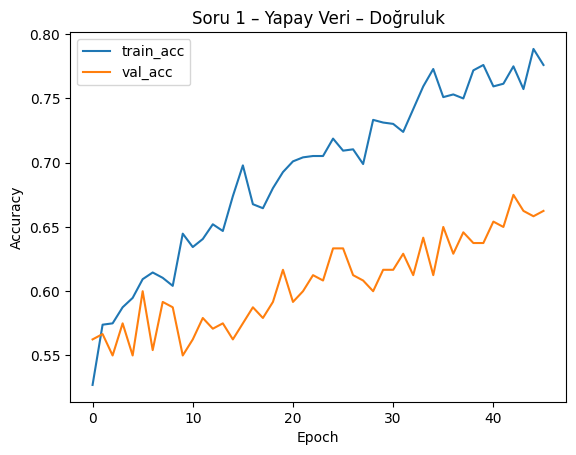

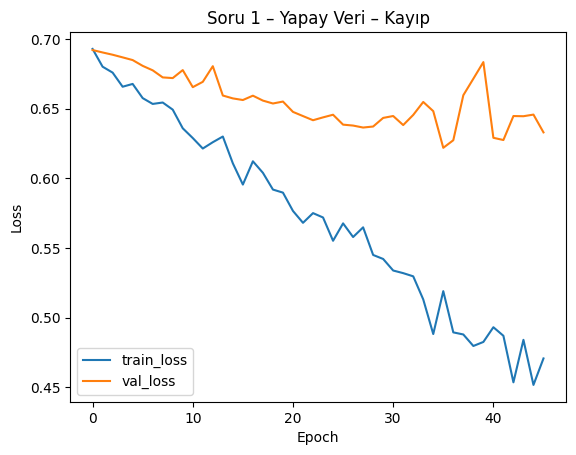

Soru 1 – Değerlendirme: {'accuracy': 0.65, 'f1': 0.6470588235294118, 'precision': 0.652542372881356, 'recall/sensitivity': 0.6416666666666667, 'specificity': 0.6583333333333279}


In [3]:

# === Yapay veri (örnek) ===
from sklearn.datasets import make_classification

N_SAMPLES = 1200
N_FEATURES = 60   # bir örnekte 60 zaman-adımı / özellik
X, y = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES,
                           n_informative=20, n_redundant=10,
                           n_repeated=0, n_classes=2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train_s, X_val_s = scale_fit_transform(X_train, X_val)
print('Şekiller:', X_train_s.shape, X_val_s.shape, 'y:', np.bincount(y_train), np.bincount(y_val))

# === Model ===
model = build_1d_cnn(input_len=X_train_s.shape[1], n_classes=2, optimizer='adam')

cb = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

hist = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=50, batch_size=32, verbose=0, callbacks=cb
)

plot_history(hist, title='Soru 1 – Yapay Veri')
y_prob = model.predict(X_val_s, verbose=0).ravel()
metrics, y_pred = evaluate_binary_metrics(y_val, y_prob, threshold=0.5)
print('Soru 1 – Değerlendirme:', metrics)



## Soru 2 — Çapraz Doğrulama (K‑Fold) ile Başarım

Aşağıda **StratifiedKFold (k=5)** ile her fold’da modeli baştan kurup eğitiyoruz; metriklerin **ortalamasını** raporluyoruz.


In [4]:

def cross_validate_binary(X, y, k=5, optimizer='adam', epochs=50, batch_size=32):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    results = []
    fold = 1
    for tr_idx, va_idx in kf.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        X_tr_s, X_va_s = scale_fit_transform(X_tr, X_va)

        model = build_1d_cnn(X_tr_s.shape[1], 2, optimizer=optimizer)
        cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
        hist = model.fit(X_tr_s, y_tr, validation_data=(X_va_s, y_va),
                         epochs=epochs, batch_size=batch_size, verbose=0, callbacks=cb)

        y_prob = model.predict(X_va_s, verbose=0).ravel()
        m, _ = evaluate_binary_metrics(y_va, y_prob)
        m['fold'] = fold
        results.append(m)
        print(f"Fold {fold} -> acc={m['accuracy']:.3f}, f1={m['f1']:.3f}")
        fold += 1

    df = pd.DataFrame(results)
    print('\nK-Fold Ortalama:')
    print(df[['accuracy','f1','precision','recall/sensitivity','specificity']].mean().to_dict())
    return df

cv_results = cross_validate_binary(X, y, k=5, optimizer='adam', epochs=50, batch_size=32)
cv_results


Fold 1 -> acc=0.512, f1=0.049
Fold 2 -> acc=0.533, f1=0.619
Fold 3 -> acc=0.617, f1=0.500
Fold 4 -> acc=0.683, f1=0.712
Fold 5 -> acc=0.696, f1=0.700

K-Fold Ortalama:
{'accuracy': 0.6083333333333333, 'f1': 0.5159075592679929, 'precision': 0.7182475190000629, 'recall/sensitivity': 0.5304958677685951, 'specificity': 0.6861484593837478}


,accuracy,f1,precision,recall/sensitivity,specificity,fold
0,0.512500,0.048780,1.000000,0.025000,1.000000,1
1,0.533333,0.619048,0.522989,0.758333,0.308333,2
2,0.616667,0.500000,0.718750,0.383333,0.850000,3
3,0.683333,0.712121,0.652778,0.783333,0.583333,4
4,0.695833,0.699588,0.696721,0.702479,0.689076,5



## Soru 3 — F1, Precision, Sensitivity (Recall), Specificity

Yukarıda hem tek bir ayrım hem de K‑Fold içinde metrikler hesaplandı. Aşağıdaki hücre, **karışıklık matrisi** ve ayrıntılı raporu gösterir.


Confusion Matrix:
 [[79 41]
 [43 77]]


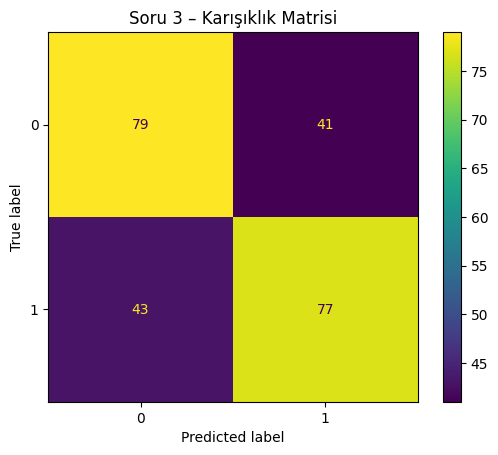


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       120
           1       0.65      0.64      0.65       120

    accuracy                           0.65       240
   macro avg       0.65      0.65      0.65       240
weighted avg       0.65      0.65      0.65       240



In [5]:

from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val, (y_prob>=0.5).astype(int))
print('Confusion Matrix:\n', cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(); plt.title('Soru 3 – Karışıklık Matrisi'); plt.show()

print('\nClassification Report:')
print(classification_report(y_val, (y_prob>=0.5).astype(int)))



## Soru 4 — **Diyabet** Veri Seti ile 1D‑ESA

Aşağıdaki kod **Pima Indians Diabetes** (`diabetes.csv`) dosyasını **çalışma dizininde** arar.  
Dosya bulunamazsa, aynı özellik isimleriyle **sentetik** (benzer dağılımlı) bir veri kümesi üretir (kod çalışsın diye).  
Elinizde gerçek `diabetes.csv` varsa, dosyayı bu defterin olduğu klasöre koyun ve hücreyi yeniden çalıştırın.


In [7]:

PIMA_PATH = 'diabetes.csv'  # Elinizde varsa bu adla aynı klasöre koyun.

pima_columns = [
    'Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome'
]

if os.path.exists(PIMA_PATH):
    df_diab = pd.read_csv(PIMA_PATH)
    # Kolon adlarını uyumlu hale getirelim (varsa)
    for c in pima_columns:
        if c not in df_diab.columns and c != 'Outcome':
            pass
    if 'Outcome' not in df_diab.columns:
        # Etiket kolonu adı farklıysa tahmin etmeye çalış
        label_col = [c for c in df_diab.columns if c.lower() in ('outcome','label','target','class')]
        assert label_col, 'Etiket kolonu bulunamadı, lütfen "Outcome" isimli kolonu ekleyin.'
        df_diab = df_diab.rename(columns={label_col[0]:'Outcome'})
    print('Gerçek Pima veri seti yüklendi:', df_diab.shape)
else:
    # Sentetik veri üret (768 örnek, 8 özellik + Outcome)
    from sklearn.datasets import make_classification
    Xsyn, ysyn = make_classification(n_samples=768, n_features=8, n_informative=6,
                                     n_redundant=2, n_classes=2, weights=[0.65,0.35],
                                     random_state=SEED)
    df_diab = pd.DataFrame(Xsyn, columns=pima_columns[:-1])
    df_diab['Outcome'] = ysyn
    print('Uyarı: diabetes.csv bulunamadı; sentetik veri üretildi:', df_diab.shape)

display(df_diab.head())


Gerçek Pima veri seti yüklendi: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


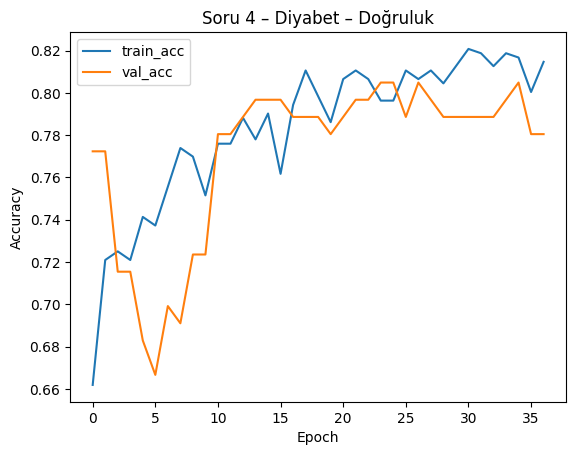

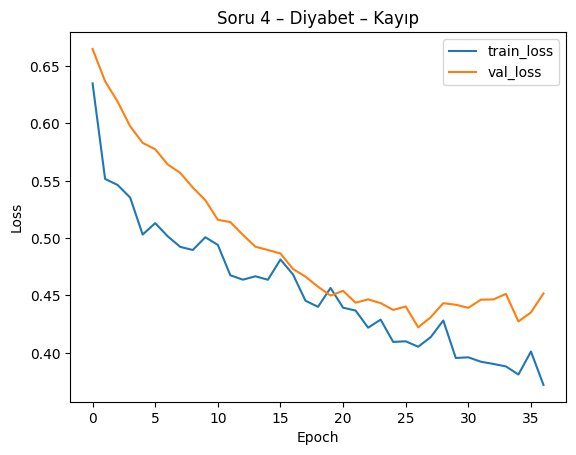

Soru 4 – Test Metrikleri: {'accuracy': 0.7467532467532467, 'f1': 0.6548672566371682, 'precision': 0.6271186440677966, 'recall/sensitivity': 0.6851851851851852, 'specificity': 0.7799999999999923}


In [8]:

# Train/Val ayrımı
X_d = df_diab.drop(columns=['Outcome']).values.astype('float32')
y_d = df_diab['Outcome'].values.astype('int32')

X_tr, X_te, y_tr, y_te = train_test_split(X_d, y_d, test_size=0.2, random_state=SEED, stratify=y_d)
X_tr_s, X_te_s = scale_fit_transform(X_tr, X_te)

model_d = build_1d_cnn(input_len=X_tr_s.shape[1], n_classes=2, optimizer='adam')
cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
hist_d = model_d.fit(X_tr_s, y_tr, validation_split=0.2, epochs=80, batch_size=32, verbose=0, callbacks=cb)

plot_history(hist_d, title='Soru 4 – Diyabet')
y_prob_d = model_d.predict(X_te_s, verbose=0).ravel()
metrics_d, y_pred_d = evaluate_binary_metrics(y_te, y_prob_d, threshold=0.5)
print('Soru 4 – Test Metrikleri:', metrics_d)



## Soru 5 — Optimizasyon Algoritmaları Karşılaştırması

Aşağıda farklı **optimizer**’lar denenir ve **F1** ile **accuracy** ortalaması yazdırılır.


In [9]:

def compare_optimizers(X, y, optimizers=('adam','rmsprop','sgd','adagrad','adamax','nadam'),
                        k=5, epochs=50, batch_size=32):
    rows = []
    for opt in optimizers:
        print('\n===> Optimizer:', opt)
        df = cross_validate_binary(X, y, k=k, optimizer=opt, epochs=epochs, batch_size=batch_size)
        row = df[['accuracy','f1','precision','recall/sensitivity','specificity']].mean().to_dict()
        row['optimizer'] = opt
        rows.append(row)
    res = pd.DataFrame(rows).sort_values(by=['f1','accuracy'], ascending=False)
    return res.reset_index(drop=True)

optim_summary = compare_optimizers(X_d, y_d, optimizers=('adam','rmsprop','sgd','adagrad','adamax','nadam'),
                                   k=5, epochs=50, batch_size=32)
optim_summary



===> Optimizer: adam
Fold 1 -> acc=0.753, f1=0.635
Fold 2 -> acc=0.786, f1=0.645
Fold 3 -> acc=0.740, f1=0.512


C:\Users\The Coder Farmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Fold 4 -> acc=0.654, f1=0.000
Fold 5 -> acc=0.758, f1=0.584

K-Fold Ortalama:
{'accuracy': 0.7381970970206264, 'f1': 0.4752482919621066, 'precision': 0.5802905982905984, 'recall/sensitivity': 0.40922431865828096, 'specificity': 0.9139999999999908}

===> Optimizer: rmsprop
Fold 1 -> acc=0.773, f1=0.660
Fold 2 -> acc=0.779, f1=0.679
Fold 3 -> acc=0.740, f1=0.487
Fold 4 -> acc=0.732, f1=0.518
Fold 5 -> acc=0.706, f1=0.615

K-Fold Ortalama:
{'accuracy': 0.7460232577879637, 'f1': 0.5919301238327563, 'precision': 0.6855703819989534, 'recall/sensitivity': 0.5484975541579316, 'specificity': 0.8519999999999914}

===> Optimizer: sgd
Fold 1 -> acc=0.753, f1=0.612
Fold 2 -> acc=0.805, f1=0.681
Fold 3 -> acc=0.766, f1=0.654
Fold 4 -> acc=0.712, f1=0.522
Fold 5 -> acc=0.739, f1=0.636

K-Fold Ortalama:
{'accuracy': 0.7551311433664376, 'f1': 0.6210089764867087, 'precision': 0.6782475769844192, 'recall/sensitivity': 0.5781970649895178, 'specificity': 0.8499999999999914}

===> Optimizer: adagrad
Fold 1 

C:\Users\The Coder Farmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Fold 3 -> acc=0.649, f1=0.000
Fold 4 -> acc=0.725, f1=0.523
Fold 5 -> acc=0.778, f1=0.622

K-Fold Ortalama:
{'accuracy': 0.7435107376283847, 'f1': 0.49760610694096935, 'precision': 0.5685807885807886, 'recall/sensitivity': 0.4480083857442348, 'specificity': 0.901999999999991}


,accuracy,f1,precision,recall/sensitivity,specificity,optimizer
0,0.769485,0.632134,0.717071,0.567086,0.878,adamax
1,0.755131,0.621009,0.678248,0.578197,0.850,sgd
2,0.746023,0.591930,0.685570,0.548498,0.852,rmsprop
3,0.705645,0.499853,0.621152,0.428791,0.854,adagrad
4,0.743511,0.497606,0.568581,0.448008,0.902,nadam
5,0.738197,0.475248,0.580291,0.409224,0.914,adam
